In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from scipy.sparse import issparse
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuration GPU pour accélération
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

print("Configuration terminée ✓")

Configuration terminée ✓


In [4]:
base = r"C:\Users\hp\Desktop\pfemaster\vectors"

In [5]:
X_train_tfidf = joblib.load(base + "/X_train_tfidf.pkl")
X_test_tfidf  = joblib.load(base + "/X_test_tfidf.pkl")
y_train = joblib.load(base + "/y_train.pkl")
y_test = joblib.load(base + "/y_test.pkl")

In [6]:
print(f"X_train shape: {X_train_tfidf.shape}")
print(f"X_test shape: {X_test_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (19761, 5652)
X_test shape: (4941, 5652)
y_train shape: (19761,)
y_test shape: (4941,)


In [7]:
# Vérification du type de données
if issparse(X_train_tfidf):
    print("Données TF-IDF sparse détectées")
    X_train_dense = X_train_tfidf.toarray()
    X_test_dense = X_test_tfidf.toarray()
else:
    X_train_dense = X_train_tfidf
    X_test_dense = X_test_tfidf

Données TF-IDF sparse détectées


In [8]:
def prepare_tfidf_for_lstm(X_data, sequence_length=50):
    """
    Transforme les données TF-IDF en séquences pour LSTM
    """
    n_samples, n_features = X_data.shape
    
    # Méthode 1: Reshape en séquences basées sur les features
    if n_features >= sequence_length:
        # Tronquer ou utiliser les top features
        n_sequences = n_features // sequence_length
        X_reshaped = X_data[:, :n_sequences * sequence_length]
        X_reshaped = X_reshaped.reshape(n_samples, n_sequences, sequence_length)
    else:
        # Padding si pas assez de features
        pad_length = sequence_length - (n_features % sequence_length)
        X_padded = np.pad(X_data, ((0, 0), (0, pad_length)), mode='constant')
        n_sequences = X_padded.shape[1] // sequence_length
        X_reshaped = X_padded.reshape(n_samples, n_sequences, sequence_length)
    
    return X_reshaped


In [9]:
# Paramètres de séquence
SEQ_LENGTH = 50  # Ajustez selon vos besoins
N_FEATURES_PER_SEQ = 100  # Nombre de features TF-IDF par séquence

In [10]:
# Méthode optimisée: utiliser les top features et créer des séquences
n_top_features = min(5000, X_train_dense.shape[1])  # Limiter pour la performance
X_train_selected = X_train_dense[:, :n_top_features]
X_test_selected = X_test_dense[:, :n_top_features]

In [11]:
#Reshape pour LSTM
X_train_lstm = prepare_tfidf_for_lstm(X_train_selected, N_FEATURES_PER_SEQ)
X_test_lstm = prepare_tfidf_for_lstm(X_test_selected, N_FEATURES_PER_SEQ)

print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")

X_train_lstm shape: (19761, 50, 100)
X_test_lstm shape: (4941, 50, 100)


In [12]:
# PRÉPARATION DES LABELS


In [13]:
# Encoder les labels si nécessaire
if isinstance(y_train[0], str):
    print("Encodage des labels texte...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    classes = label_encoder.classes_
else:
    y_train_encoded = np.array(y_train)
    y_test_encoded = np.array(y_test)
    classes = np.unique(y_train_encoded)

n_classes = len(classes)
print(f"Nombre de classes: {n_classes}")
print(f"Classes: {classes}")

# Conversion en format catégoriel pour classification
if n_classes > 2:
    y_train_cat = to_categorical(y_train_encoded, n_classes)
    y_test_cat = to_categorical(y_test_encoded, n_classes)
    loss_function = 'categorical_crossentropy'
    final_activation = 'softmax'
    metrics = ['accuracy']
else:
    y_train_cat = y_train_encoded
    y_test_cat = y_test_encoded
    loss_function = 'binary_crossentropy'
    final_activation = 'sigmoid'
    metrics = ['accuracy']

Nombre de classes: 3
Classes: [0 1 2]


In [14]:
def build_tfidf_lstm_model(input_shape, n_classes, lstm_units=64, dense_units=32, dropout_rate=0.3):
    """
    Modèle LSTM optimisé pour données TF-IDF
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units//2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate//2),
        Dense(n_classes if n_classes > 2 else 1, activation=final_activation)
    ])
    return model

# Construction du modèle
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
model = build_tfidf_lstm_model(input_shape, n_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_function,
    metrics=metrics
)

print("Modèle LSTM pour TF-IDF créé ✓")
model.summary()

Modèle LSTM pour TF-IDF créé ✓


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,811 (218.01 KB)

 Trainable params: 55,811 (218.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# ENTRAÎNEMENT


In [46]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, monitor='val_loss')
]

print("Début de l'entraînement...")
history = model.fit(
    X_train_lstm, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("Entraînement terminé ✓")

Début de l'entraînement...
Epoch 1/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3417 - loss: 1.0967 - val_accuracy: 0.4485 - val_loss: 1.0357 - learning_rate: 0.0010
Epoch 2/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4516 - loss: 1.0291 - val_accuracy: 0.5092 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 3/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5090 - loss: 0.9625 - val_accuracy: 0.5454 - val_loss: 0.9283 - learning_rate: 0.0010
Epoch 4/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5474 - loss: 0.9213 - val_accuracy: 0.5745 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 5/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5839 - loss: 0.8840 - val_accuracy: 0.5897 - val_loss: 0.8747 - learning_rate: 0.0010
Epoch 6/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6008 - loss: 0.8585 - val_accuracy: 0.6210 - val_loss: 0.8418 - learning_rate: 0.0010
Epoch 7/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms

In [47]:
# ÉVALUATION DU MODÈLE
# Prédictions
print("Génération des prédictions...")
train_pred_prob = model.predict(X_train_lstm)
test_pred_prob = model.predict(X_test_lstm)

# Conversion en classes prédites
if n_classes > 2:
    train_pred = np.argmax(train_pred_prob, axis=1)
    test_pred = np.argmax(test_pred_prob, axis=1)
    train_true = np.argmax(y_train_cat, axis=1) if y_train_cat.ndim > 1 else y_train_encoded
    test_true = np.argmax(y_test_cat, axis=1) if y_test_cat.ndim > 1 else y_test_encoded
else:
    train_pred = (train_pred_prob > 0.5).astype(int).flatten()
    test_pred = (test_pred_prob > 0.5).astype(int).flatten()
    train_true = y_train_encoded
    test_true = y_test_encoded

# Calcul des métriques
train_accuracy = accuracy_score(train_true, train_pred)
test_accuracy = accuracy_score(test_true, test_pred)

print("\n=== RÉSULTATS D'ÉVALUATION ===")
print(f"Précision d'entraînement: {train_accuracy:.4f}")
print(f"Précision de test: {test_accuracy:.4f}")

Génération des prédictions...
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

=== RÉSULTATS D'ÉVALUATION ===
Précision d'entraînement: 0.7409
Précision de test: 0.6831


In [48]:
 # apport de classification détaillé
print("\n=== RAPPORT DE CLASSIFICATION (TEST) ===")
if isinstance(y_train[0], str):
    target_names = label_encoder.classes_
else:
    target_names = [f"Classe_{i}" for i in range(n_classes)]

print(classification_report(test_true, test_pred, target_names=target_names))



=== RAPPORT DE CLASSIFICATION (TEST) ===
              precision    recall  f1-score   support

    Classe_0       0.66      0.65      0.65      1631
    Classe_1       0.71      0.65      0.68      1672
    Classe_2       0.68      0.76      0.72      1638

    accuracy                           0.68      4941
   macro avg       0.68      0.68      0.68      4941
weighted avg       0.68      0.68      0.68      4941



In [49]:
# Conversion en classes prédites
if n_classes > 2:
    train_pred = np.argmax(train_pred_prob, axis=1)
    test_pred = np.argmax(test_pred_prob, axis=1)
    train_true = np.argmax(y_train_cat, axis=1) if y_train_cat.ndim > 1 else y_train_encoded
    test_true = np.argmax(y_test_cat, axis=1) if y_test_cat.ndim > 1 else y_test_encoded
else:
    train_pred = (train_pred_prob > 0.5).astype(int).flatten()
    test_pred = (test_pred_prob > 0.5).astype(int).flatten()
    train_true = y_train_encoded
    test_true = y_test_encoded

In [50]:
# VISUALISATIONS


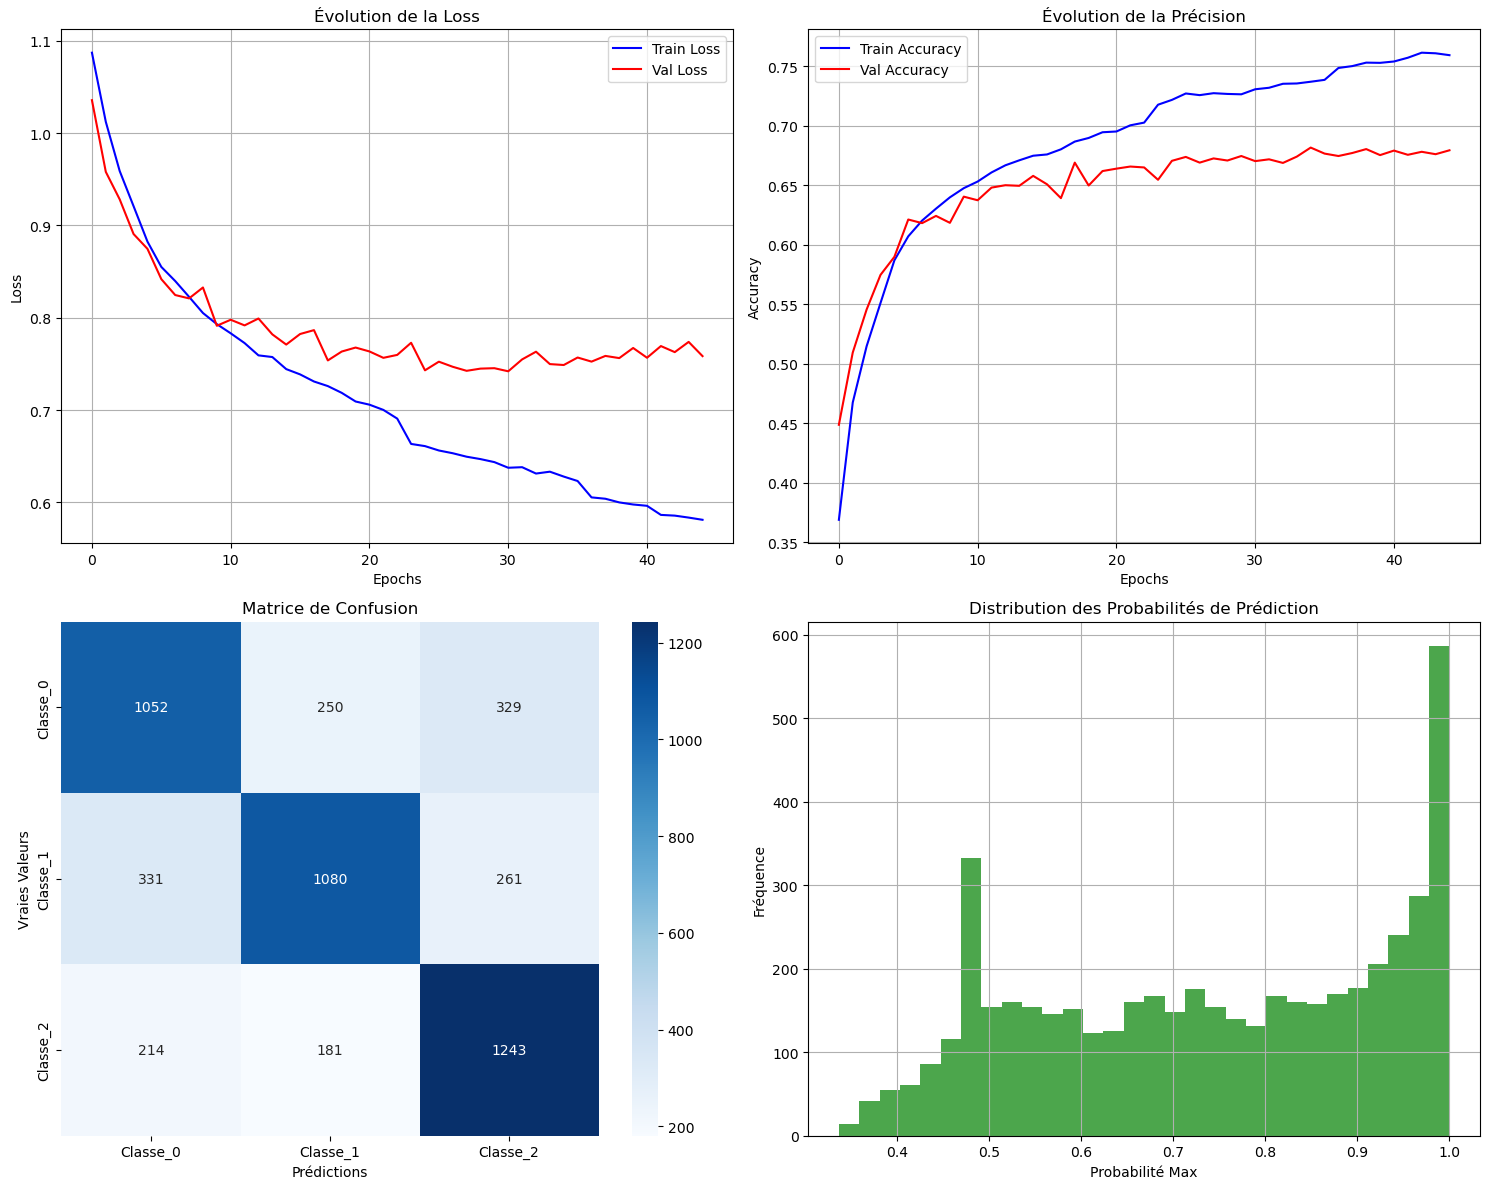

In [51]:
# Configuration des graphiques
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Historique d'entraînement - Loss
axes[0,0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0,0].plot(history.history['val_loss'], label='Val Loss', color='red')
axes[0,0].set_title('Évolution de la Loss')
axes[0,0].set_xlabel('Epochs')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Historique d'entraînement - Accuracy
axes[0,1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[0,1].plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
axes[0,1].set_title('Évolution de la Précision')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Matrice de confusion
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=target_names, yticklabels=target_names)
axes[1,0].set_title('Matrice de Confusion')
axes[1,0].set_xlabel('Prédictions')
axes[1,0].set_ylabel('Vraies Valeurs')

# 4. Distribution des probabilités de prédiction
if n_classes > 2:
    max_probs = np.max(test_pred_prob, axis=1)
else:
    max_probs = test_pred_prob.flatten()

axes[1,1].hist(max_probs, bins=30, alpha=0.7, color='green')
axes[1,1].set_title('Distribution des Probabilités de Prédiction')
axes[1,1].set_xlabel('Probabilité Max')
axes[1,1].set_ylabel('Fréquence')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [52]:
# MODÈLE AMÉLIORÉ BIDIRECTIONNEL


In [53]:
# Modèle 1: LSTM Plus Simple (moins de paramètres)
def build_simple_lstm(input_shape, n_classes):
    """Modèle LSTM très simple - souvent plus efficace"""
    model = Sequential([
        LSTM(32, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(n_classes if n_classes > 2 else 1, activation=final_activation)
    ])
    return model

# Modèle 2: LSTM avec plus de régularisation
def build_regularized_lstm(input_shape, n_classes):
    """Modèle avec plus de régularisation pour éviter l'overfitting"""
    model = Sequential([
        LSTM(48, return_sequences=True, input_shape=input_shape, 
             recurrent_dropout=0.2, dropout=0.2),
        LSTM(24, return_sequences=False, recurrent_dropout=0.2, dropout=0.2),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(n_classes if n_classes > 2 else 1, activation=final_activation)
    ])
    return model

# Modèle 3: Bidirectionnel simple
def build_bidirectional_lstm(input_shape, n_classes):
    """Modèle bidirectionnel mais plus simple"""
    model = Sequential([
        Bidirectional(LSTM(32, return_sequences=False), input_shape=input_shape),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(n_classes if n_classes > 2 else 1, activation=final_activation)
    ])
    return model

print("\n=== TEST DE DIFFÉRENTES VARIANTES ===")
models_to_test = {
    'Simple': build_simple_lstm,
    'Régularisé': build_regularized_lstm,
    'Bidirectionnel': build_bidirectional_lstm
}

# Tableau pour stocker tous les résultats
results_data = []

# Ajouter le modèle original
results_data.append({
    'Modèle': 'Original',
    'Précision_Test': test_accuracy,
    'Précision_Train': train_accuracy,
    'Epochs_Total': len(history.history['loss']),
    'Temps_Entraînement': 'N/A',
    'Paramètres': model.count_params(),
    'Loss_Final': history.history['val_loss'][-1],
    'Overfitting': abs(train_accuracy - test_accuracy)
})

results_comparison = {'Original': test_accuracy}


=== TEST DE DIFFÉRENTES VARIANTES ===


In [54]:
for model_name, model_builder in models_to_test.items():
    print(f"\nTest du modèle {model_name}...")
    
    # Mesurer le temps d'entraînement
    import time
    start_time = time.time()
    
    test_model = model_builder(input_shape, n_classes)
    test_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss_function,
        metrics=metrics
    )
    
    # Entraînement plus court pour comparaison rapide
    test_history = test_model.fit(
        X_train_lstm, y_train_cat,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )
    
    training_time = time.time() - start_time
    
    # Évaluation sur test
    test_pred_prob = test_model.predict(X_test_lstm, verbose=0)
    if n_classes > 2:
        test_pred = np.argmax(test_pred_prob, axis=1)
    else:
        test_pred = (test_pred_prob > 0.5).astype(int).flatten()
    
    test_acc = accuracy_score(test_true, test_pred)
    
    # Évaluation sur train pour détecter l'overfitting
    train_pred_prob = test_model.predict(X_train_lstm, verbose=0)
    if n_classes > 2:
        train_pred = np.argmax(train_pred_prob, axis=1)
    else:
        train_pred = (train_pred_prob > 0.5).astype(int).flatten()
    
    train_acc = accuracy_score(train_true, train_pred)
    
    # Stocker les résultats dans le tableau
    results_data.append({
        'Modèle': model_name,
        'Précision_Test': test_acc,
        'Précision_Train': train_acc,
        'Epochs_Total': len(test_history.history['loss']),
        'Temps_Entraînement': f"{training_time:.2f}s",
        'Paramètres': test_model.count_params(),
        'Loss_Final': test_history.history['val_loss'][-1],
        'Overfitting': abs(train_acc - test_acc)
    })
    
    results_comparison[model_name] = test_acc
    print(f"Précision {model_name}: {test_acc:.4f}")

# Créer le DataFrame des résultats
results_df = pd.DataFrame(results_data)



Test du modèle Simple...
Précision Simple: 0.6537

Test du modèle Régularisé...
Précision Régularisé: 0.6317

Test du modèle Bidirectionnel...
Précision Bidirectionnel: 0.6693


In [55]:
# Trier par précision test (décroissant)
results_df = results_df.sort_values('Précision_Test', ascending=False).reset_index(drop=True)

# Ajouter une colonne de rang
results_df['Rang'] = range(1, len(results_df) + 1)

# Réorganiser les colonnes
results_df = results_df[['Rang', 'Modèle', 'Précision_Test', 'Précision_Train', 
                        'Overfitting', 'Paramètres', 'Epochs_Total', 
                        'Temps_Entraînement', 'Loss_Final']]

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MODÈLES LSTM")
print("="*80)
print(results_df.round(4))



TABLEAU COMPARATIF DES MODÈLES LSTM
   Rang          Modèle  Précision_Test  Précision_Train  Overfitting  \
0     1        Original          0.6831           0.7409       0.0578   
1     2  Bidirectionnel          0.6693           0.7094       0.0401   
2     3          Simple          0.6537           0.6831       0.0294   
3     4      Régularisé          0.6317           0.6481       0.0165   

   Paramètres  Epochs_Total Temps_Entraînement  Loss_Final  
0       55811            45                N/A      0.7585  
1       35139            20             98.97s      0.7478  
2       17603            20             77.99s      0.7812  
3       36067            20            263.37s      0.8313  



🏆 MEILLEUR MODÈLE: Original
🎯 MEILLEURE PRÉCISION: 0.6831


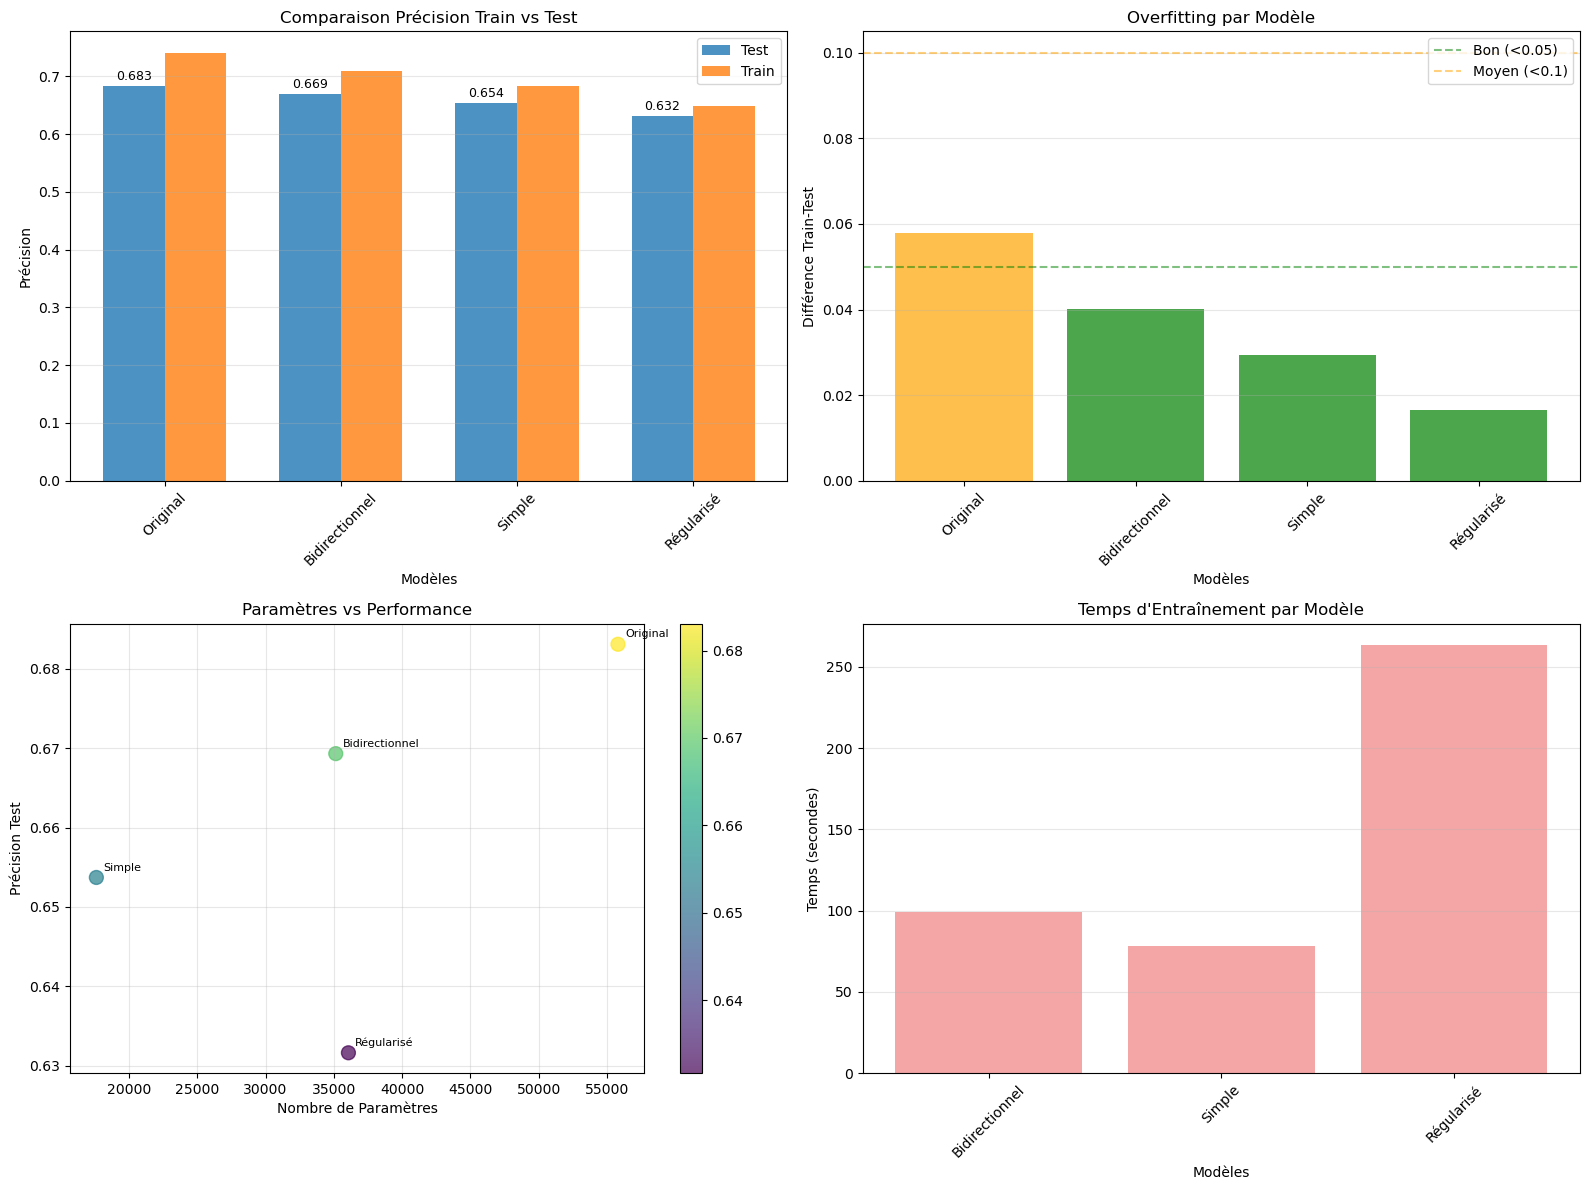

In [56]:
# Affichage stylé du tableau
print(f"\n🏆 MEILLEUR MODÈLE: {results_df.iloc[0]['Modèle']}")
print(f"🎯 MEILLEURE PRÉCISION: {results_df.iloc[0]['Précision_Test']:.4f}")

# Graphiques de comparaison améliorés
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Graphique en barres des précisions
model_names = results_df['Modèle'].tolist()
test_accuracies = results_df['Précision_Test'].tolist()
train_accuracies = results_df['Précision_Train'].tolist()

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0,0].bar(x - width/2, test_accuracies, width, label='Test', alpha=0.8)
bars2 = axes[0,0].bar(x + width/2, train_accuracies, width, label='Train', alpha=0.8)

axes[0,0].set_xlabel('Modèles')
axes[0,0].set_ylabel('Précision')
axes[0,0].set_title('Comparaison Précision Train vs Test')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(model_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Graphique de l'overfitting
overfitting_values = results_df['Overfitting'].tolist()
colors = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' for x in overfitting_values]

bars = axes[0,1].bar(model_names, overfitting_values, color=colors, alpha=0.7)
axes[0,1].set_xlabel('Modèles')
axes[0,1].set_ylabel('Différence Train-Test')
axes[0,1].set_title('Overfitting par Modèle')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)
axes[0,1].axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Bon (<0.05)')
axes[0,1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Moyen (<0.1)')
axes[0,1].legend()

# 3. Nombre de paramètres vs Performance
params = results_df['Paramètres'].tolist()
scatter = axes[1,0].scatter(params, test_accuracies, c=test_accuracies, 
                           cmap='viridis', s=100, alpha=0.7)
axes[1,0].set_xlabel('Nombre de Paramètres')
axes[1,0].set_ylabel('Précision Test')
axes[1,0].set_title('Paramètres vs Performance')
for i, model in enumerate(model_names):
    axes[1,0].annotate(model, (params[i], test_accuracies[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0])

# 4. Temps d'entraînement
# Convertir les temps en float (ignorer 'N/A')
times = []
models_with_time = []
for i, time_str in enumerate(results_df['Temps_Entraînement']):
    if time_str != 'N/A':
        times.append(float(time_str.replace('s', '')))
        models_with_time.append(model_names[i])

if times:
    bars = axes[1,1].bar(models_with_time, times, alpha=0.7, color='lightcoral')
    axes[1,1].set_xlabel('Modèles')
    axes[1,1].set_ylabel('Temps (secondes)')
    axes[1,1].set_title('Temps d\'Entraînement par Modèle')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [58]:
# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Modèle']
best_accuracy = results_df.iloc[0]['Précision_Test']

# Reconstruire et entraîner le meilleur modèle
if best_model_name == 'Original':
    final_model = model
    final_accuracy = test_accuracy
else:
    print(f"\nRe-entraînement du meilleur modèle ({best_model_name}) avec plus d'epochs...")
    final_model = models_to_test[best_model_name](input_shape, n_classes)
    final_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss_function,
        metrics=metrics
    )
    
    final_history = final_model.fit(
        X_train_lstm, y_train_cat,
        epochs=40,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    final_pred_prob = final_model.predict(X_test_lstm)
    if n_classes > 2:
        final_pred = np.argmax(final_pred_prob, axis=1)
    else:
        final_pred = (final_pred_prob > 0.5).astype(int).flatten()
    
    final_accuracy = accuracy_score(test_true, final_pred)

In [59]:
print("\n=== ANALYSE DES ERREURS ===")

# Identifier les échantillons mal classés
misclassified_indices = np.where(test_pred != test_true)[0]
print(f"Nombre d'échantillons mal classés: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    # Analyser les probabilités des prédictions incorrectes
    if n_classes > 2:
        misclassified_probs = np.max(test_pred_prob[misclassified_indices], axis=1)
    else:
        misclassified_probs = test_pred_prob[misclassified_indices].flatten()
    
    print(f"Probabilité moyenne des erreurs: {np.mean(misclassified_probs):.4f}")
    print(f"Probabilité médiane des erreurs: {np.median(misclassified_probs):.4f}")


=== ANALYSE DES ERREURS ===
Nombre d'échantillons mal classés: 1634
Probabilité moyenne des erreurs: 0.5777
Probabilité médiane des erreurs: 0.5525


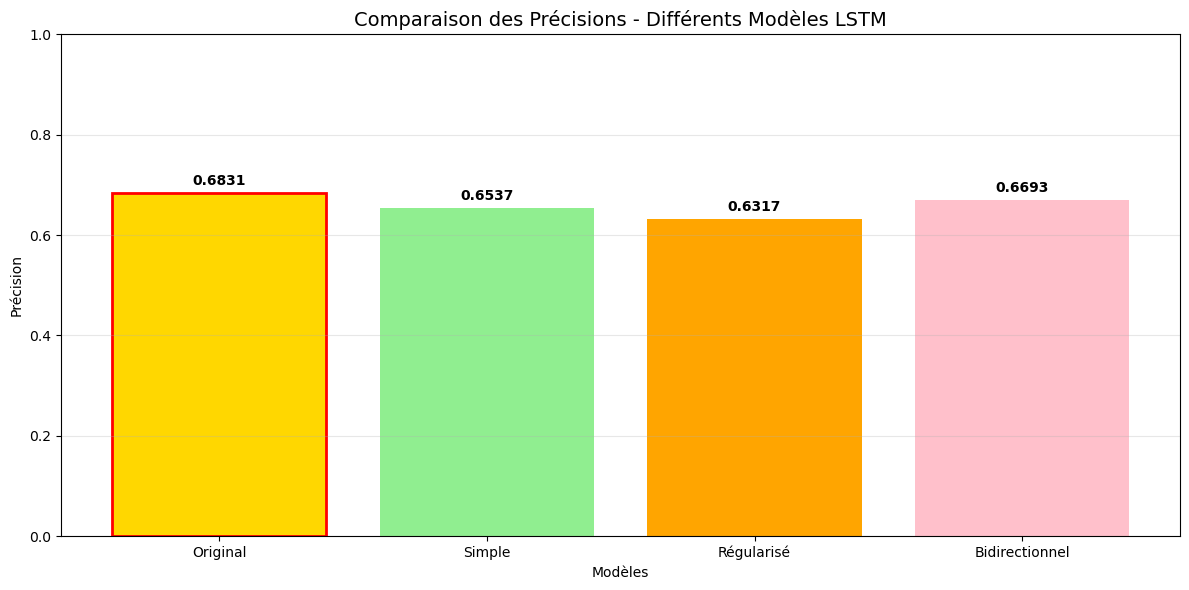

In [60]:
# Graphique de comparaison
plt.figure(figsize=(12, 6))

# Barres de comparaison
model_names = list(results_comparison.keys())
accuracies = list(results_comparison.values())

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Comparaison des Précisions - Différents Modèles LSTM', fontsize=14)
plt.xlabel('Modèles')
plt.ylabel('Précision')
plt.ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Mettre en évidence le meilleur modèle
best_idx = model_names.index(best_model_name)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 3) Entraînement avec EarlyStopping
early = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
history = model.fit(
    X_tr, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early],
    verbose=1
)

In [ ]:
# 4) Tracer les courbes Loss & Accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Évolution de la Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Évolution de la Précision")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 5) Évaluation finale sur le test set
y_proba = model.predict(X_te)
y_pred  = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}\n")
print("Classification Report :\n", classification_report(y_test, y_pred))


In [ ]:
# 6) Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
labels = ['MAR','ALG','TUN']  # adapte selon ton mapping 0,1,2
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Matrice de confusion CNN+LSTM")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

Comment ça fonctionne :

Reshape transforme (batch_size, input_dim) en (batch_size, input_dim, 1) pour la couche Conv1D.

Conv1D + MaxPool extrait les motifs locaux dans le vecteur TF‑IDF.

LSTM capture les dépendances à plus longue portée.

Dense final pour la classification multiclasse.

EarlyStopping arrête l’entraînement dès que la validation ne s’améliore plus.

On trace ensuite les courbes d’entraînement, on évalue sur le test set, et on affiche la matrice de confusion.

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np


In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, channels, length)
        x = x.permute(0, 2, 1)  # for LSTM: (batch_size, seq_len, input_size)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, vectorizer_name, results_df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CNN_LSTM(input_dim=X_train.shape[1], hidden_dim=128, num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Data loaders
    train_ds = TensorDataset(torch.tensor(X_train.toarray()).float(), torch.tensor(y_train).long())
    test_ds = TensorDataset(torch.tensor(X_test.toarray()).float(), torch.tensor(y_test).long())
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Training loop
    model.train()
    for epoch in range(5):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    results_df.loc[len(results_df)] = [vectorizer_name, 'CNN+LSTM', acc, f1]
    print(f"{vectorizer_name} ➤ Accuracy: {acc:.4f}, F1: {f1:.4f}")
    return results_df


In [16]:
import joblib

base = "C:/Users/hp/Desktop/pfemaster/vectors"

X_train_tfidf = joblib.load(base + "/X_train_tfidf.pkl")
X_test_tfidf  = joblib.load(base + "/X_test_tfidf.pkl")

X_train_glove = joblib.load(base + "/X_train_glove.pkl")
X_test_glove  = joblib.load(base + "/X_test_glove.pkl")

X_train_w2v = joblib.load(base + "/X_train_w2v.pkl")
X_test_w2v  = joblib.load(base + "/X_test_w2v.pkl")
X_train_bert = joblib.load(base + "/X_train_bert.pkl")
X_test_bert = joblib.load(base + "/X_test_bert.pkl")

y_train = joblib.load(base + "/y_train.pkl")
y_test = joblib.load(base + "/y_test.pkl")


In [ ]:
results = pd.DataFrame(columns=["Vectorizer", "Model", "Accuracy", "F1-Score"])

results = train_and_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, "TFIDF", results)

print("\n=== Résumé des performances ===")
print(results)


In [ ]:
results = train_and_evaluate(X_train_w2v, y_train, X_test_w2v, y_test, "W2V", results)


In [18]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, monitor='val_loss')
]

In [19]:
print("Début de l'entraînement...")
history = model.fit(
    X_train_bert, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("Entraînement terminé ✓")

Début de l'entraînement...
Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 768), dtype=float32). Expected shape (None, 50, 100), but input has incompatible shape (32, 768)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 768), dtype=float32)
  • training=True
  • mask=None